In [1]:
import pandas as pd

data = pd.read_csv('data/new_product_info3.csv')

# Random Forest - kfolds with word2vec

In [2]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

ings = pd.read_csv('data/ingredients_dataset.csv')

# Convert all values in 'ingredient' column to strings
ings['ingredient'] = ings['ingredient'].astype(str)

# Tokenize the ingredients
ings['tokenized_ingredients'] = ings['ingredient'].apply(simple_preprocess)

# Train Word2Vec on the tokenized ingredients
word2vec_model = Word2Vec(
    sentences=ings['tokenized_ingredients'],
    vector_size=100,       # Dimensionality of the embeddings
    window=5,              # Context window size
    min_count=1,           # Include all ingredients, even rare ones
    workers=4,             # Use 4 CPU cores for training
    sg=1,                  # Use Skip-Gram model
    epochs=10              # Number of iterations over the corpus
)

In [2]:
import numpy as np
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

word2vec_model = Word2Vec.load("data/model/ingredient_word2vec.model")

# Tokenize the ingredients
data['tokenized_ingredients'] = data['ingredients'].apply(simple_preprocess)

def get_sentence_vector(model, sentence):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Take the average of word vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words match

# Generate embeddings for each product's ingredients
data['ingredient_embeddings'] = data['tokenized_ingredients'].apply(
    lambda x: get_sentence_vector(word2vec_model, x)
)

In [4]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Ensure X is a NumPy array
X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

# Try different K values
k_values = [3, 5, 10, 15]
scores = {}

for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    model = RandomForestClassifier(random_state=42)

    # Perform Cross-Validation to get accuracy
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    scores[k] = np.mean(cv_scores)

# Find the best K
best_k = max(scores, key=scores.get)
best_accuracy = scores[best_k]

print(f"Best K: {best_k} with Accuracy: {best_accuracy:.4f}")

# Perform classification using the best K
skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)
reports = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train model on the fold
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Generate classification report for the fold
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

# Aggregate classification reports across folds
final_report = {}

for key in reports[0]:
    if isinstance(reports[0][key], dict):  # Ensure it's a dictionary (for classes and averages)
        final_report[key] = {}
        for metric in reports[0][key]:  # Iterate over precision, recall, f1-score, support
            if all(isinstance(fold[key][metric], (int, float)) for fold in reports if key in fold):
                final_report[key][metric] = np.mean([fold[key][metric] for fold in reports if key in fold])

# Convert to DataFrame for better visualization
final_report_df = pd.DataFrame(final_report).transpose()

print("\nFinal Classification Report (Averaged Over Folds):")
print(final_report_df)


Best K: 15 with Accuracy: 0.7969

Final Classification Report (Averaged Over Folds):
              precision    recall  f1-score     support
Fragrance      0.971315  0.969209  0.970073   73.666667
Hair           0.756126  0.665064  0.706851   75.266667
Makeup         0.837642  0.857761  0.846880  125.133333
Other          0.807703  0.418346  0.544448   42.400000
Skincare       0.696467  0.842679  0.762046  123.733333
macro avg      0.813851  0.750612  0.766060  440.200000
weighted avg   0.803563  0.796903  0.790596  440.200000


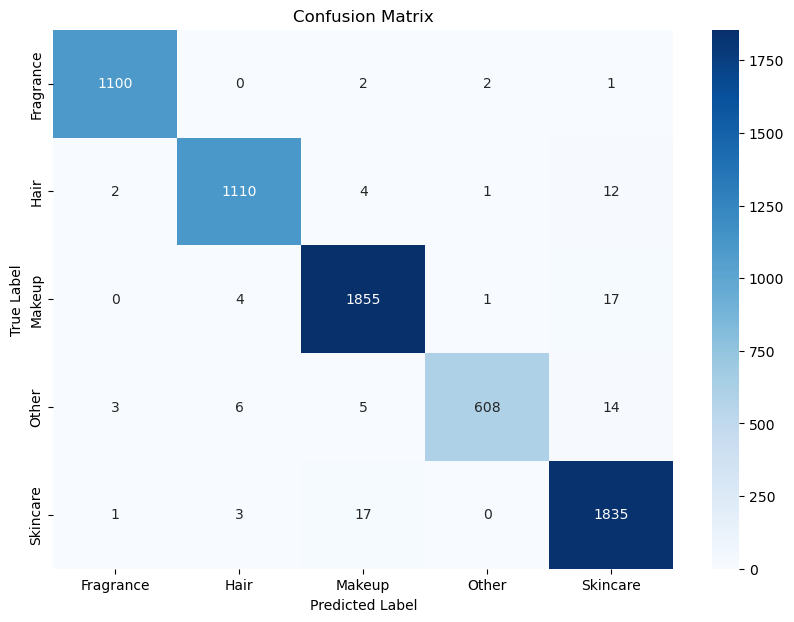

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the entire dataset (or a separate test set if available)
y_pred = model.predict(X)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


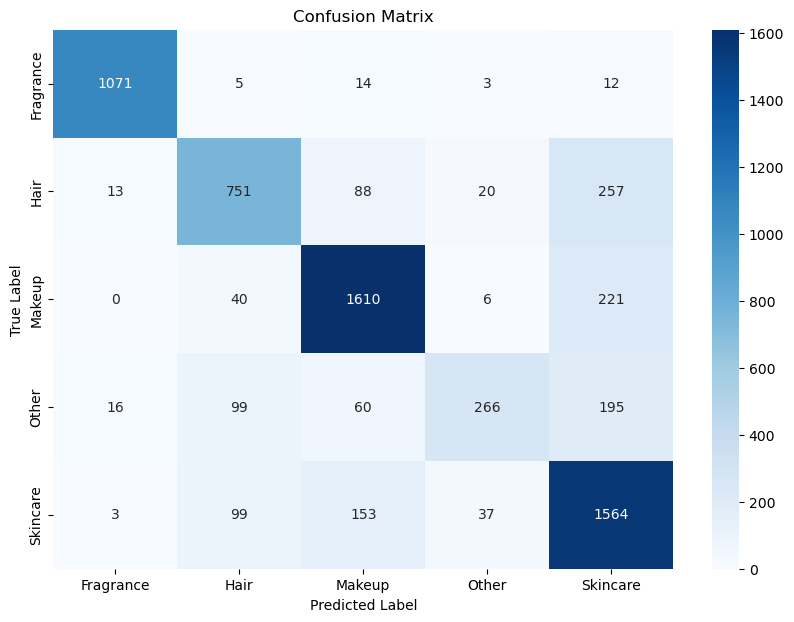

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Collect all true labels and predictions
all_y_true = []
all_y_pred = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train model on the fold
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Store results
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(all_y_true, all_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


----------------------------------------------------------------------------------------------------

Best K: 15 with Accuracy: 0.7969

Fold 1 Confusion Matrix:
[[ 72   0   2   0   0]
 [  2  46   7   0  20]
 [  0   4 110   0  11]
 [  2   9   2  17  13]
 [  0  11  10   1 102]]


<Figure size 800x600 with 0 Axes>

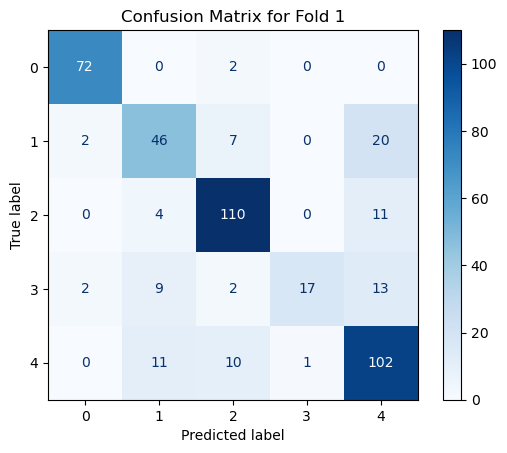


Fold 2 Confusion Matrix:
[[ 72   1   0   0   1]
 [  0  55   6   0  15]
 [  0   1 111   0  13]
 [  0   2   4  23  13]
 [  1   4  11   2 106]]


<Figure size 800x600 with 0 Axes>

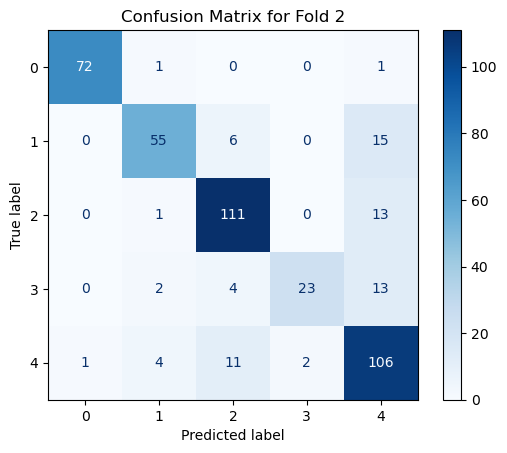


Fold 3 Confusion Matrix:
[[ 69   1   0   2   2]
 [  0  55   2   1  18]
 [  0   0 105   3  17]
 [  0   7   4  19  12]
 [  0   3   4   3 114]]


<Figure size 800x600 with 0 Axes>

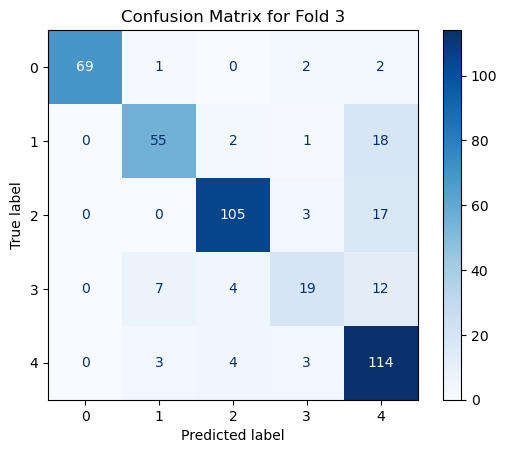


Fold 4 Confusion Matrix:
[[ 73   0   0   0   1]
 [  3  56   3   1  13]
 [  0   3 102   0  20]
 [  0   7   3  22  10]
 [  0   5   7   4 107]]


<Figure size 800x600 with 0 Axes>

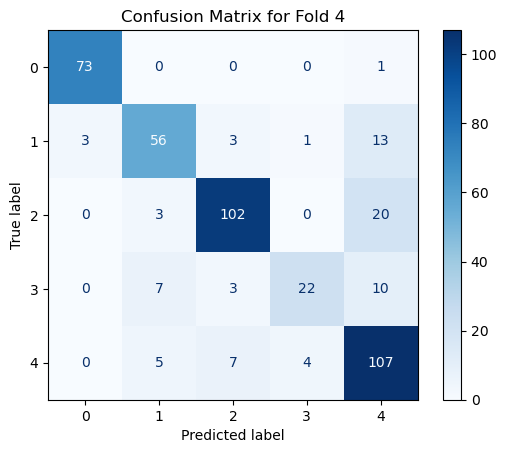


Fold 5 Confusion Matrix:
[[ 71   0   1   0   2]
 [  2  47   4   6  17]
 [  0   1 113   0  11]
 [  0   6   6  13  17]
 [  0   9  11   4  99]]


<Figure size 800x600 with 0 Axes>

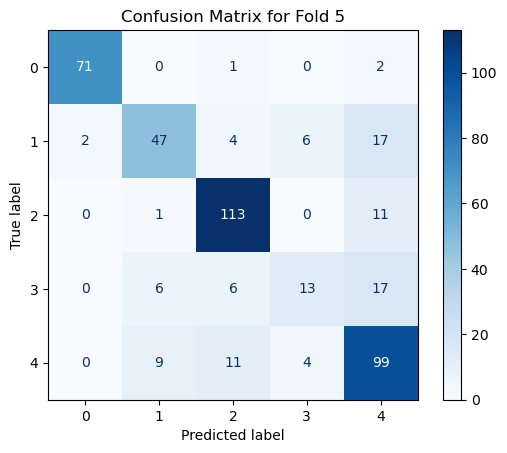


Fold 6 Confusion Matrix:
[[ 73   0   1   0   0]
 [  0  47   8   0  20]
 [  0   3 109   1  13]
 [  0   6   6  14  16]
 [  1   7   7   1 107]]


<Figure size 800x600 with 0 Axes>

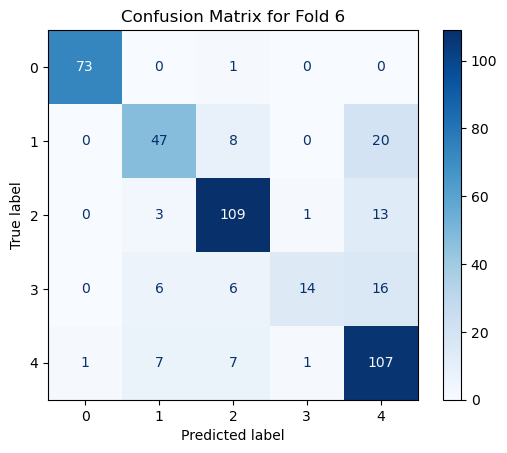


Fold 7 Confusion Matrix:
[[ 72   0   1   0   1]
 [  2  46   4   0  23]
 [  0   5 105   1  15]
 [  0   7   3  20  12]
 [  0   6  13   1 103]]


<Figure size 800x600 with 0 Axes>

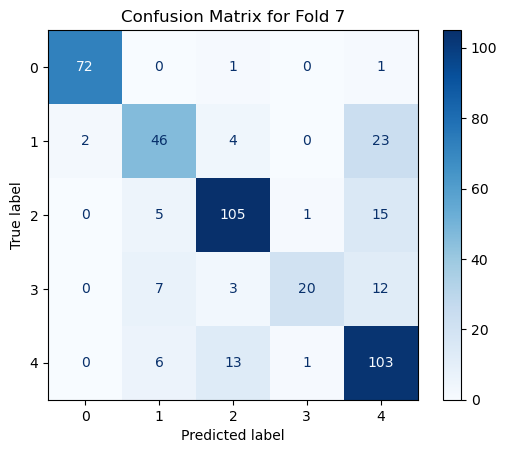


Fold 8 Confusion Matrix:
[[ 73   0   1   0   0]
 [  1  50   7   2  15]
 [  0   2 100   0  23]
 [  2   5   3  17  15]
 [  0   6   6   4 108]]


<Figure size 800x600 with 0 Axes>

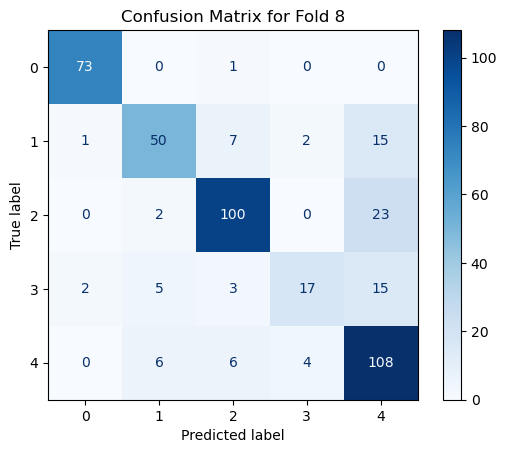


Fold 9 Confusion Matrix:
[[ 71   0   2   0   1]
 [  0  53   5   1  16]
 [  0   3 113   0   9]
 [  0   4   7  22   9]
 [  0   7  10   3 104]]


<Figure size 800x600 with 0 Axes>

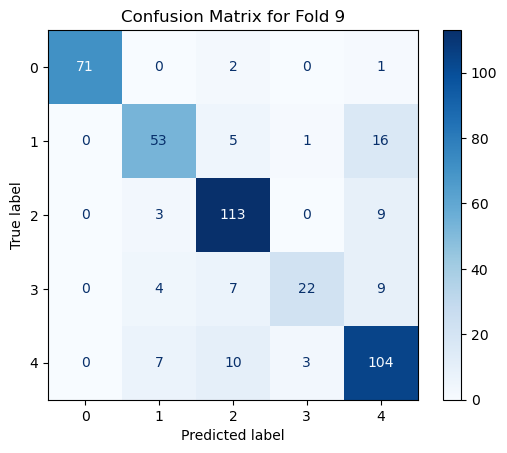


Fold 10 Confusion Matrix:
[[ 73   1   0   0   0]
 [  0  55   5   0  15]
 [  0   4 103   0  18]
 [  3  11   5  11  12]
 [  0   4  11   3 106]]


<Figure size 800x600 with 0 Axes>

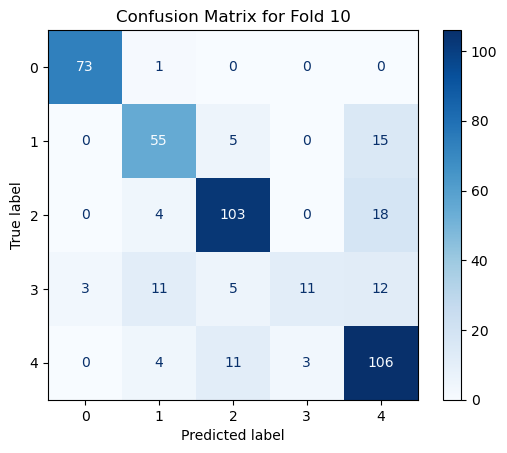


Fold 11 Confusion Matrix:
[[ 70   0   2   0   1]
 [  0  53   9   1  12]
 [  0   4 112   0   9]
 [  1   8   1  20  13]
 [  1   8  13   2 100]]


<Figure size 800x600 with 0 Axes>

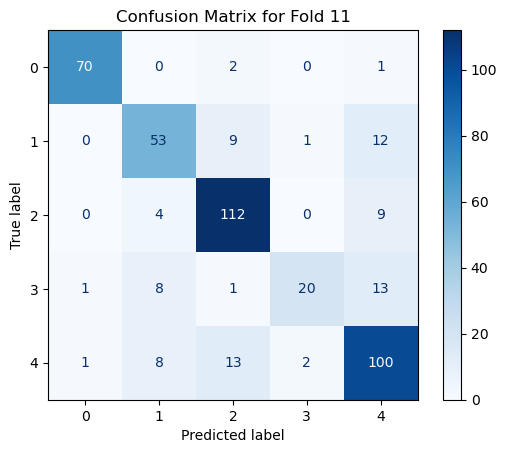


Fold 12 Confusion Matrix:
[[ 71   0   1   0   1]
 [  1  46   7   4  17]
 [  0   3 109   1  12]
 [  2   7   6  12  16]
 [  0  13  10   5  96]]


<Figure size 800x600 with 0 Axes>

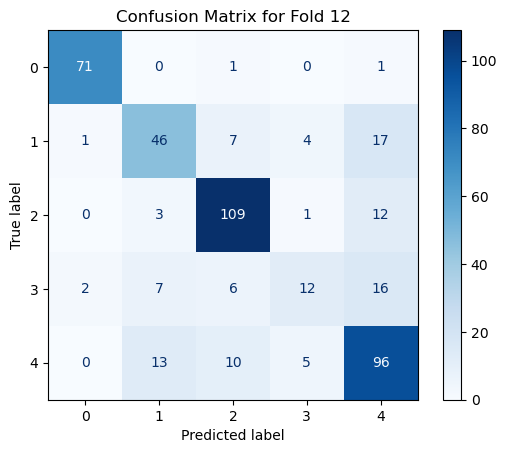


Fold 13 Confusion Matrix:
[[ 69   2   1   0   1]
 [  0  45   7   3  20]
 [  0   1 109   0  15]
 [  2   5   2  22  12]
 [  0   8  10   3 103]]


<Figure size 800x600 with 0 Axes>

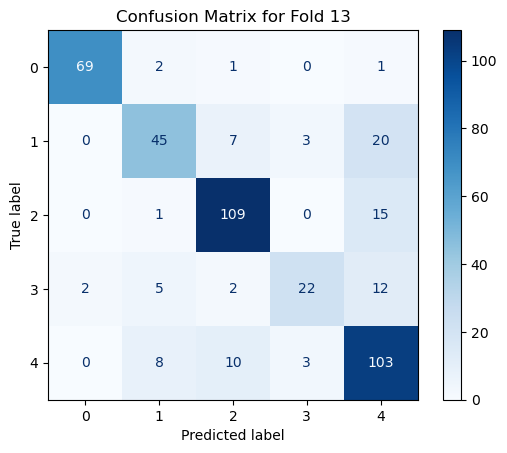


Fold 14 Confusion Matrix:
[[ 72   0   0   0   1]
 [  0  41  10   0  24]
 [  0   2 104   0  19]
 [  3  10   5  11  14]
 [  0   5  13   1 105]]


<Figure size 800x600 with 0 Axes>

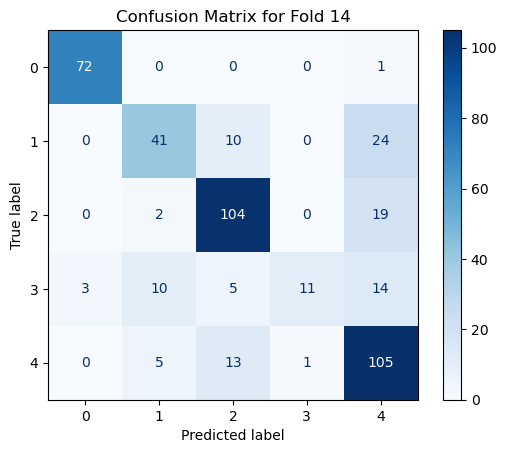


Fold 15 Confusion Matrix:
[[ 70   0   2   1   0]
 [  2  56   4   1  12]
 [  0   4 105   0  16]
 [  1   5   3  23  11]
 [  0   3  17   0 104]]


<Figure size 800x600 with 0 Axes>

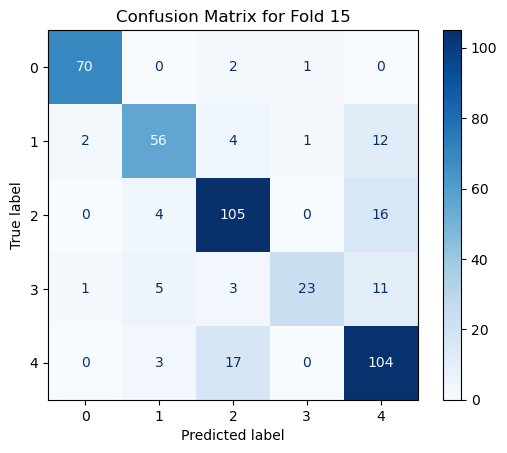


Final Classification Report (Averaged Over Folds):
              precision    recall  f1-score     support
Fragrance      0.971315  0.969209  0.970073   73.666667
Hair           0.756126  0.665064  0.706851   75.266667
Makeup         0.837642  0.857761  0.846880  125.133333
Other          0.807703  0.418346  0.544448   42.400000
Skincare       0.696467  0.842679  0.762046  123.733333
macro avg      0.813851  0.750612  0.766060  440.200000
weighted avg   0.803563  0.796903  0.790596  440.200000

Average Confusion Matrix Across All Folds:
[[ 71   0   0   0   0]
 [  0  50   5   1  17]
 [  0   2 107   0  14]
 [  1   6   4  17  13]
 [  0   6  10   2 104]]


<Figure size 1000x800 with 0 Axes>

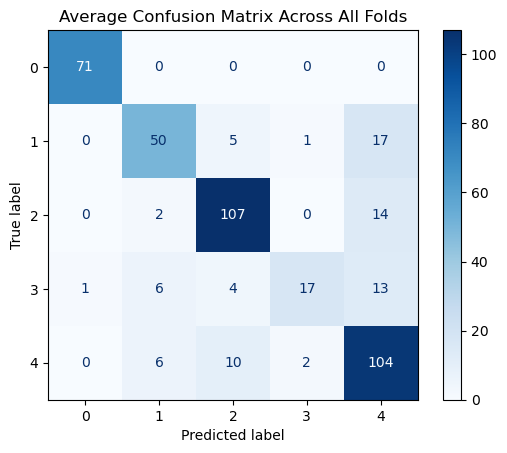


Overall Confusion Matrix from All Folds Combined:
[[1071    5   14    3   12]
 [  13  751   88   20  257]
 [   0   40 1610    6  221]
 [  16   99   60  266  195]
 [   3   99  153   37 1564]]


<Figure size 1000x800 with 0 Axes>

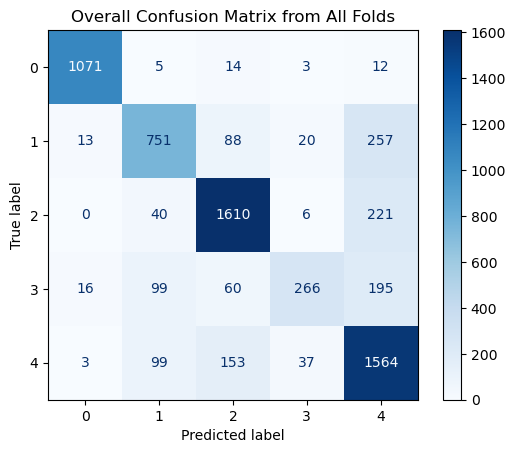


Confusion Matrix using cross_val_predict:
[[ 999   22   34   23   27]
 [  15  614  124   27  349]
 [   1   67 1524   18  267]
 [  45  102  108  137  244]
 [   5  143  183   42 1483]]


<Figure size 1000x800 with 0 Axes>

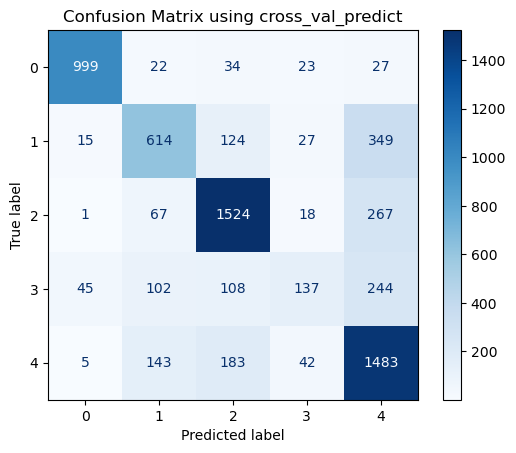

<Figure size 1000x800 with 0 Axes>

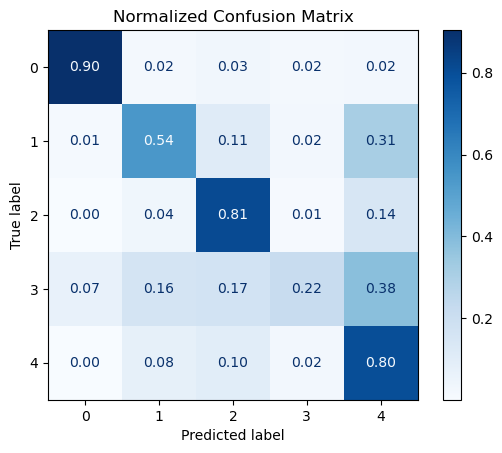

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure X is a NumPy array
X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

# Try different K values
k_values = [3, 5, 10, 15]
scores = {}

for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    model = RandomForestClassifier(random_state=42)

    # Perform Cross-Validation to get accuracy
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    scores[k] = np.mean(cv_scores)

# Find the best K
best_k = max(scores, key=scores.get)
best_accuracy = scores[best_k]

print(f"Best K: {best_k} with Accuracy: {best_accuracy:.4f}")

# Perform classification using the best K
skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)
reports = []
all_y_test = []
all_y_pred = []
fold_confusion_matrices = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train model on the fold
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Store actual and predicted values for later use
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

    # Generate classification report for the fold
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

    # Calculate confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    fold_confusion_matrices.append(cm)

    print(f"\nFold {i+1} Confusion Matrix:")
    print(cm)

    # Visualize confusion matrix for each fold (optional)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for Fold {i+1}')
    plt.show()

# Aggregate classification reports across folds
final_report = {}

for key in reports[0]:
    if isinstance(reports[0][key], dict):  # Ensure it's a dictionary (for classes and averages)
        final_report[key] = {}
        for metric in reports[0][key]:  # Iterate over precision, recall, f1-score, support
            if all(isinstance(fold[key][metric], (int, float)) for fold in reports if key in fold):
                final_report[key][metric] = np.mean([fold[key][metric] for fold in reports if key in fold])

# Convert to DataFrame for better visualization
final_report_df = pd.DataFrame(final_report).transpose()

print("\nFinal Classification Report (Averaged Over Folds):")
print(final_report_df)

# Method 1: Calculate an average confusion matrix across all folds
# This is useful to see the average performance pattern
if fold_confusion_matrices[0].shape == fold_confusion_matrices[-1].shape:  # Ensure all matrices have same shape
    avg_cm = np.mean(fold_confusion_matrices, axis=0).astype(int)
    print("\nAverage Confusion Matrix Across All Folds:")
    print(avg_cm)

    # Visualize the average confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm)
    disp.plot(cmap='Blues')
    plt.title('Average Confusion Matrix Across All Folds')
    plt.show()

# Method 2: Create a single confusion matrix from all predictions
# This gives a more holistic view of model performance
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
overall_cm = confusion_matrix(all_y_test, all_y_pred)

print("\nOverall Confusion Matrix from All Folds Combined:")
print(overall_cm)

# Visualize the overall confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=overall_cm)
disp.plot(cmap='Blues')
plt.title('Overall Confusion Matrix from All Folds')
plt.show()

# Method 3: Another approach using cross_val_predict to get predictions
# This is more compact and preferred for getting an overall confusion matrix
model = RandomForestClassifier(random_state=42)
y_pred_cv = cross_val_predict(model, X, y, cv=best_k)
cm_cv_predict = confusion_matrix(y, y_pred_cv)

print("\nConfusion Matrix using cross_val_predict:")
print(cm_cv_predict)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cv_predict)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix using cross_val_predict')
plt.show()

# You can also normalize the confusion matrix to show proportions instead of counts
cm_normalized = cm_cv_predict.astype('float') / cm_cv_predict.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap='Blues', values_format='.2f')  # Format to show 2 decimal places
plt.title('Normalized Confusion Matrix')
plt.show()

-------------------------------------------------------------------------------------------------------

Best K: 15 with Accuracy: 0.7957

Fold 1 - Training Accuracy: 0.9981, Testing Accuracy: 0.7868

Fold 2 - Training Accuracy: 0.9979, Testing Accuracy: 0.8299

Fold 3 - Training Accuracy: 0.9981, Testing Accuracy: 0.8050

Fold 4 - Training Accuracy: 0.9979, Testing Accuracy: 0.8227

Fold 5 - Training Accuracy: 0.9979, Testing Accuracy: 0.7773

Fold 6 - Training Accuracy: 0.9982, Testing Accuracy: 0.7977

Fold 7 - Training Accuracy: 0.9982, Testing Accuracy: 0.7818

Fold 8 - Training Accuracy: 0.9979, Testing Accuracy: 0.7932

Fold 9 - Training Accuracy: 0.9977, Testing Accuracy: 0.8273

Fold 10 - Training Accuracy: 0.9979, Testing Accuracy: 0.7886

Fold 11 - Training Accuracy: 0.9981, Testing Accuracy: 0.8091

Fold 12 - Training Accuracy: 0.9977, Testing Accuracy: 0.7591

Fold 13 - Training Accuracy: 0.9984, Testing Accuracy: 0.7886

Fold 14 - Training Accuracy: 0.9977, Testing Accuracy: 0.7614

Fold 15 - Training Accuracy: 0.9979, Testing Accuracy: 0.8068

Average Training Accuracy: 0.9

<Figure size 1200x1000 with 0 Axes>

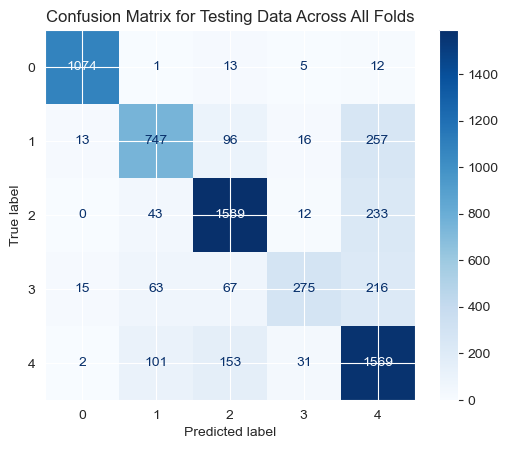

<Figure size 1200x1000 with 0 Axes>

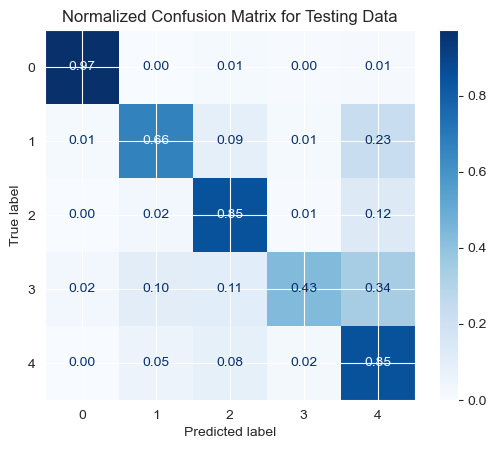


Final Classification Report for Test Data (Averaged Over Folds):
              precision    recall  f1-score     support
Fragrance      0.972996  0.971924  0.972337   73.666667
Hair           0.784205  0.661567  0.716932   75.266667
Makeup         0.829464  0.846565  0.837241  125.133333
Other          0.816706  0.432669  0.559400   42.400000
Skincare       0.686490  0.845358  0.757451  123.733333
macro avg      0.817972  0.751617  0.768672  440.200000
weighted avg   0.804411  0.795694  0.790099  440.200000


In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure X is a NumPy array
X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

# Try different K values
k_values = [3, 5, 10, 15]
scores = {}

for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    model = RandomForestClassifier(random_state=42)

    # Perform Cross-Validation to get accuracy
    cv_scores = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_scores.append(accuracy_score(y_test, y_pred))

    scores[k] = np.mean(cv_scores)

# Find the best K
best_k = max(scores, key=scores.get)
best_accuracy = scores[best_k]

print(f"Best K: {best_k} with Accuracy: {best_accuracy:.4f}")

# Perform classification using the best K
skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)
reports = []
all_y_test = []  # Store all test set actual values
all_y_pred = []  # Store all test set predictions
training_accuracies = []  # Store training accuracies for each fold
testing_accuracies = []   # Store testing accuracies for each fold

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train model on the fold
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Calculate training accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    training_accuracies.append(train_accuracy)

    # Calculate testing accuracy and make predictions on test set
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    testing_accuracies.append(test_accuracy)

    print(f"\nFold {i+1} - Training Accuracy: {train_accuracy:.4f}, Testing Accuracy: {test_accuracy:.4f}")

    # Store actual and predicted values for later confusion matrix
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

    # Generate classification report for the fold
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

# Print average training and testing accuracies
avg_train_accuracy = np.mean(training_accuracies)
avg_test_accuracy = np.mean(testing_accuracies)
print(f"\nAverage Training Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Testing Accuracy: {avg_test_accuracy:.4f}")

# Create a single confusion matrix from all test predictions across folds
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
test_confusion_matrix = confusion_matrix(all_y_test, all_y_pred)

print("\nConfusion Matrix for Testing Data Across All Folds:")
print(test_confusion_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Testing Data Across All Folds')
plt.show()

# You can also create a normalized confusion matrix to show proportions
test_cm_normalized = test_confusion_matrix.astype('float') / test_confusion_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm_normalized)
disp.plot(cmap='Blues', values_format='.2f')  # Format to show 2 decimal places
plt.title('Normalized Confusion Matrix for Testing Data')
plt.show()

# Aggregate classification reports across folds for test data
final_report = {}
for key in reports[0]:
    if isinstance(reports[0][key], dict):
        final_report[key] = {}
        for metric in reports[0][key]:
            if all(isinstance(fold[key][metric], (int, float)) for fold in reports if key in fold):
                final_report[key][metric] = np.mean([fold[key][metric] for fold in reports if key in fold])

# Convert to DataFrame for better visualization
final_report_df = pd.DataFrame(final_report).transpose()
print("\nFinal Classification Report for Test Data (Averaged Over Folds):")
print(final_report_df)

## Random forest kfolds with word2vec and hyperparameter tuning

In [18]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Ensure X is a NumPy array
X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

# Try different K values
k_values = [3, 5, 10, 15]
scores = {}

# Find the best K for Stratified K-Fold
for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    model = RandomForestClassifier(random_state=42)

    # Perform Cross-Validation to get accuracy
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    scores[k] = np.mean(cv_scores)

# Find the best K
best_k = max(scores, key=scores.get)
best_accuracy = scores[best_k]
print(f"Best K: {best_k} with Accuracy: {best_accuracy:.4f}")

# Hyperparameter tuning for RandomForestClassifier
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'max_depth': [None, 10, 20, 30],     # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],     # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]        # Minimum samples in each leaf
}

# Use StratifiedKFold with the best K found
skf = StratifiedKFold(n_splits=best_k, shuffle=True, random_state=42)

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid,
                           cv=skf,
                           scoring='accuracy',
                           n_jobs=-1, verbose=1)

grid_search.fit(X, y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the final model with best hyperparameters
final_model = RandomForestClassifier(**best_params, random_state=42)

# Perform final cross-validation
reports = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    final_model.fit(X_train, y_train)

    # Make predictions
    y_pred = final_model.predict(X_test)

    # Generate classification report for this fold
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

# Aggregate classification reports across folds
final_report = {}

for key in reports[0]:
    if isinstance(reports[0][key], dict):  # Ensure it's a dictionary (for classes and averages)
        final_report[key] = {}
        for metric in reports[0][key]:  # Iterate over precision, recall, f1-score, support
            if all(isinstance(fold[key][metric], (int, float)) for fold in reports if key in fold):
                final_report[key][metric] = np.mean([fold[key][metric] for fold in reports if key in fold])

# Convert to DataFrame for better visualization
final_report_df = pd.DataFrame(final_report).transpose()

print("\nFinal Classification Report (Averaged Over Folds):")
print(final_report_df)


Best K: 15 with Accuracy: 0.7949
Fitting 15 folds for each of 108 candidates, totalling 1620 fits
Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Final Classification Report (Averaged Over Folds):
              precision    recall  f1-score     support
Fragrance      0.970487  0.971936  0.971049   73.666667
Hair           0.793933  0.656327  0.717853   75.266667
Makeup         0.822361  0.855090  0.837830  125.133333
Other          0.811951  0.426209  0.554853   42.400000
Skincare       0.690450  0.845367  0.759635  123.733333
macro avg      0.817836  0.750986  0.768244  440.200000
weighted avg   0.804211  0.796607  0.790372  440.200000


Training Accuracy: 0.9977
Testing Accuracy: 0.7986

Confusion Matrix for Testing Data:
[[217   0   2   0   2]
 [  2 159  17   3  45]
 [  0  13 318   0  45]
 [  3  17  14  45  48]
 [  0  18  33   4 316]]


<Figure size 1200x1000 with 0 Axes>

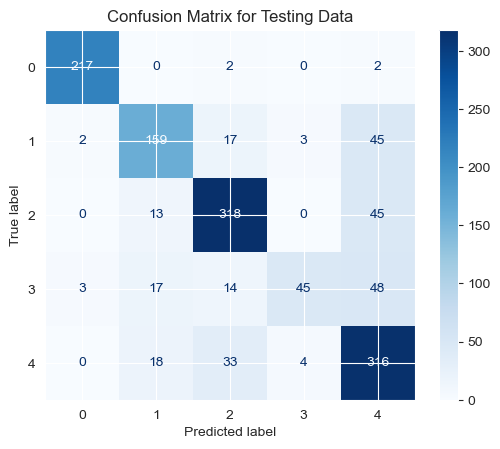

<Figure size 1200x1000 with 0 Axes>

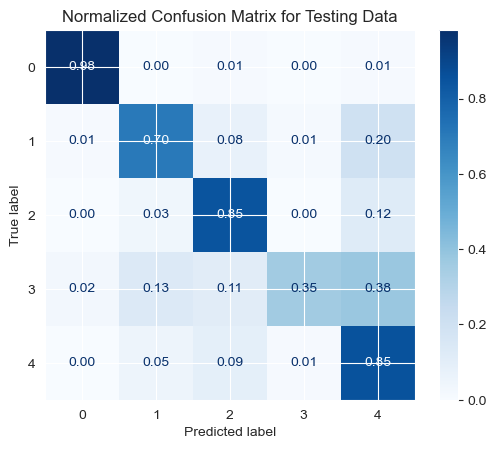


Classification Report for Test Data:
              precision    recall  f1-score   support

   Fragrance       0.98      0.98      0.98       221
        Hair       0.77      0.70      0.73       226
      Makeup       0.83      0.85      0.84       376
       Other       0.87      0.35      0.50       127
    Skincare       0.69      0.85      0.76       371

    accuracy                           0.80      1321
   macro avg       0.83      0.75      0.76      1321
weighted avg       0.81      0.80      0.79      1321


Classification Report as DataFrame:
              precision    recall  f1-score      support
Fragrance      0.977477  0.981900  0.979684   221.000000
Hair           0.768116  0.703540  0.734411   226.000000
Makeup         0.828125  0.845745  0.836842   376.000000
Other          0.865385  0.354331  0.502793   127.000000
Skincare       0.692982  0.851752  0.764208   371.000000
accuracy       0.798637  0.798637  0.798637     0.798637
macro avg      0.826417  0.747454  0.

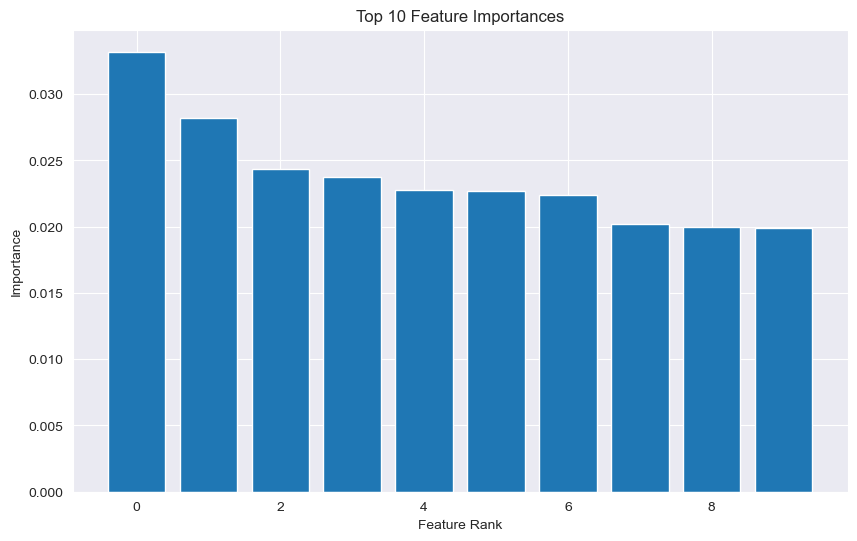

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure X is a NumPy array
X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Calculate training accuracy
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate testing accuracy
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix for the test set
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix for Testing Data:")
print(test_confusion_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Testing Data')
plt.show()

# Create a normalized confusion matrix (shows proportions instead of raw counts)
test_cm_normalized = test_confusion_matrix.astype('float') / test_confusion_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm_normalized)
disp.plot(cmap='Blues', values_format='.2f')  # Format to show 2 decimal places
plt.title('Normalized Confusion Matrix for Testing Data')
plt.show()

# Generate classification report for the test set
test_report = classification_report(y_test, y_test_pred)
print("\nClassification Report for Test Data:")
print(test_report)

# If you want a more detailed classification report as a DataFrame
test_report_dict = classification_report(y_test, y_test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report_dict).transpose()
print("\nClassification Report as DataFrame:")
print(test_report_df)

## Trying out different models with word2vec embeddings

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Ensure X is a NumPy array
X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the evaluation function
def evaluate_model(model, X, y, cv=5):
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42))
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Train-test split evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model.fit(X_train, y_train)

    # Calculate training accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training accuracy: {train_accuracy:.4f}")

    # Calculate testing accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Testing accuracy: {test_accuracy:.4f}")

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    return model

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Create SVM classifier with RBF kernel
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
}
svm_grid = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=1)
svm_grid.fit(X_train, y_train)

print(f"Best parameters: {svm_grid.best_params_}")
svm_best = svm_grid.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 100, 'gamma': 1}


In [17]:
X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

Cross-validation accuracy: 0.7969 ± 0.0043
Training accuracy: 0.9972
Testing accuracy: 0.7933

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       221
           1       0.75      0.71      0.73       226
           2       0.84      0.86      0.85       376
           3       0.73      0.35      0.47       127
           4       0.69      0.81      0.75       371

    accuracy                           0.79      1321
   macro avg       0.80      0.74      0.76      1321
weighted avg       0.79      0.79      0.79      1321



<Figure size 1000x800 with 0 Axes>

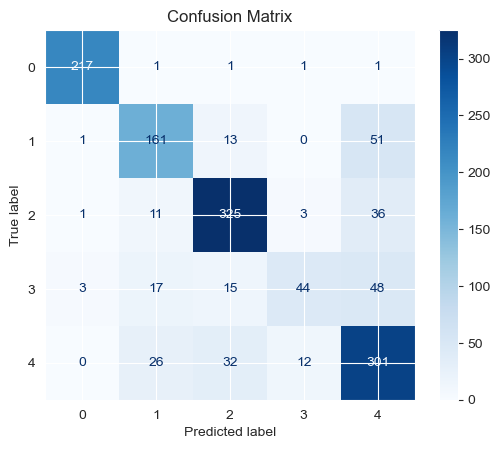

Model saved to xgboost_classifier_model.json
Label encoder saved to label_encoder.pkl


In [40]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=5,
    random_state=42
)

evaluate_model(xgb_model, X, y_encoded)

import pickle

# Save the XGBoost model
model_filename = "data/model/xgboost_classifier_model.json"
xgb_model.save_model(model_filename)

# Save the label encoder (if you're using one)
encoder_filename = "data/model/label_encoder.pkl"
with open(encoder_filename, "wb") as file:
    pickle.dump(label_encoder, file)

print(f"Model saved to {model_filename}")
print(f"Label encoder saved to {encoder_filename}")

Cross-validation accuracy: 0.7736 ± 0.0130
Training accuracy: 0.8033
Testing accuracy: 0.7835

Classification Report:
              precision    recall  f1-score   support

   Fragrance       0.95      0.98      0.96       221
        Hair       0.72      0.73      0.73       226
      Makeup       0.84      0.87      0.86       376
       Other       0.67      0.25      0.37       127
    Skincare       0.69      0.79      0.74       371

    accuracy                           0.78      1321
   macro avg       0.77      0.73      0.73      1321
weighted avg       0.78      0.78      0.77      1321



<Figure size 1000x800 with 0 Axes>

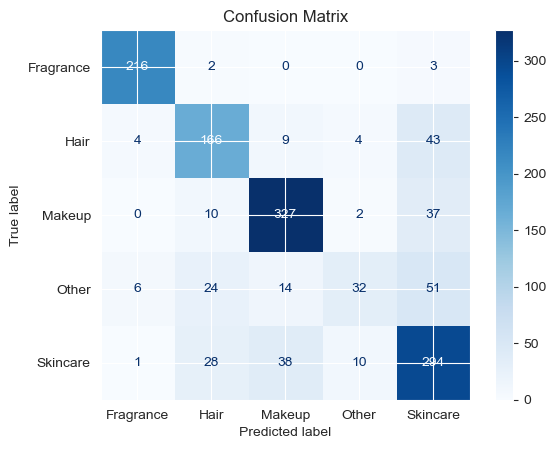

MLPClassifier(early_stopping=True, hidden_layer_sizes=(200, 100),
              learning_rate='adaptive', max_iter=500, random_state=42)

In [29]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(
    hidden_layer_sizes=(200, 100),  # Two hidden layers
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

evaluate_model(nn_model, X, y)

# With Fastext Embeddings

In [33]:
from gensim.models import FastText
from gensim.utils import simple_preprocess


ings = pd.read_csv('data/ingredients_dataset.csv')

# Convert all values in 'ingredient' column to strings
ings['ingredient'] = ings['ingredient'].astype(str)

# Tokenize the ingredients
ings['tokenized_ingredients'] = ings['ingredient'].apply(simple_preprocess)


# Train FastText on the tokenized ingredients
fasttext_model = FastText(
    sentences=ings['tokenized_ingredients'],  # Tokenized ingredients
    vector_size=100,                          # Dimensionality of word embeddings
    window=5,                                 # Context window size
    min_count=1,                              # Include all words, even rare ones
    workers=4,                                # Use 4 CPU cores for training
    sg=1,                                     # Use Skip-Gram (sg=1); CBOW if sg=0
    epochs=10                                 # Number of training iterations
)


In [34]:
import numpy as np

# Tokenize the ingredients
data['tokenized_ingredients'] = data['ingredients'].apply(simple_preprocess)

def get_sentence_vector(model, sentence):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)  # Take the average of word vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words match

# Generate embeddings for each product's ingredients
data['ingredient_embeddings'] = data['tokenized_ingredients'].apply(
    lambda x: get_sentence_vector(fasttext_model, x)
)

## Random Forest

Training Accuracy: 0.9983
Testing Accuracy: 0.7797

Confusion Matrix for Testing Data:
[[218   0   0   0   3]
 [  1 152  20   3  50]
 [  0  11 320   1  44]
 [  2  14  20  44  47]
 [  0  24  40  11 296]]


<Figure size 1200x1000 with 0 Axes>

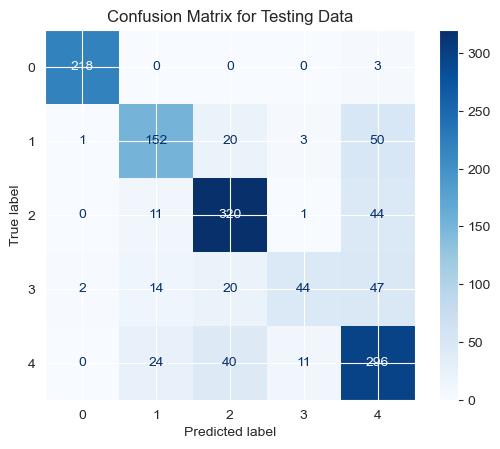

<Figure size 1200x1000 with 0 Axes>

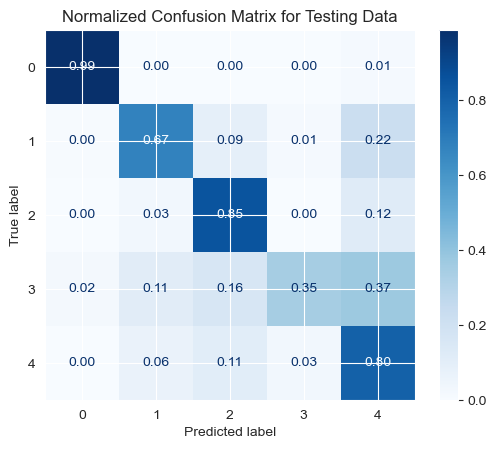


Classification Report for Test Data:
              precision    recall  f1-score   support

   Fragrance       0.99      0.99      0.99       221
        Hair       0.76      0.67      0.71       226
      Makeup       0.80      0.85      0.82       376
       Other       0.75      0.35      0.47       127
    Skincare       0.67      0.80      0.73       371

    accuracy                           0.78      1321
   macro avg       0.79      0.73      0.75      1321
weighted avg       0.78      0.78      0.77      1321


Classification Report as DataFrame:
              precision    recall  f1-score      support
Fragrance      0.986425  0.986425  0.986425   221.000000
Hair           0.756219  0.672566  0.711944   226.000000
Makeup         0.800000  0.851064  0.824742   376.000000
Other          0.745763  0.346457  0.473118   127.000000
Skincare       0.672727  0.797844  0.729963   371.000000
accuracy       0.779712  0.779712  0.779712     0.779712
macro avg      0.792227  0.730871  0.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure X is a NumPy array
X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Calculate training accuracy
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate testing accuracy
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix for the test set
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix for Testing Data:")
print(test_confusion_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=test_confusion_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Testing Data')
plt.show()

# Create a normalized confusion matrix (shows proportions instead of raw counts)
test_cm_normalized = test_confusion_matrix.astype('float') / test_confusion_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm_normalized)
disp.plot(cmap='Blues', values_format='.2f')  # Format to show 2 decimal places
plt.title('Normalized Confusion Matrix for Testing Data')
plt.show()

# Generate classification report for the test set
test_report = classification_report(y_test, y_test_pred)
print("\nClassification Report for Test Data:")
print(test_report)

# If you want a more detailed classification report as a DataFrame
test_report_dict = classification_report(y_test, y_test_pred, output_dict=True)
test_report_df = pd.DataFrame(test_report_dict).transpose()
print("\nClassification Report as DataFrame:")
print(test_report_df)


## XGBoost

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Ensure X is a NumPy array
X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define the evaluation function
def evaluate_model(model, X, y, cv=5):
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42))
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Train-test split evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model.fit(X_train, y_train)

    # Calculate training accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training accuracy: {train_accuracy:.4f}")

    # Calculate testing accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Testing accuracy: {test_accuracy:.4f}")

    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    return model

Cross-validation accuracy: 0.7969 ± 0.0043
Training accuracy: 0.9972
Testing accuracy: 0.7933

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       221
           1       0.75      0.71      0.73       226
           2       0.84      0.86      0.85       376
           3       0.73      0.35      0.47       127
           4       0.69      0.81      0.75       371

    accuracy                           0.79      1321
   macro avg       0.80      0.74      0.76      1321
weighted avg       0.79      0.79      0.79      1321



<Figure size 1000x800 with 0 Axes>

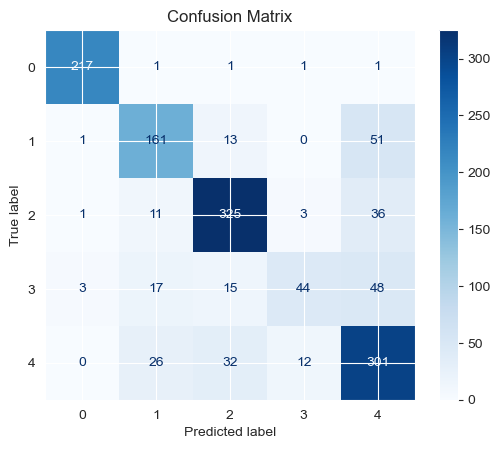

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)

In [37]:
import xgboost as xgb

X = np.vstack(data['ingredient_embeddings'])
y = np.array(data['primary_category'])

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=5,
    random_state=42
)

evaluate_model(xgb_model, X, y_encoded)

# Code to Generate Confusion Matrix in Random Forest

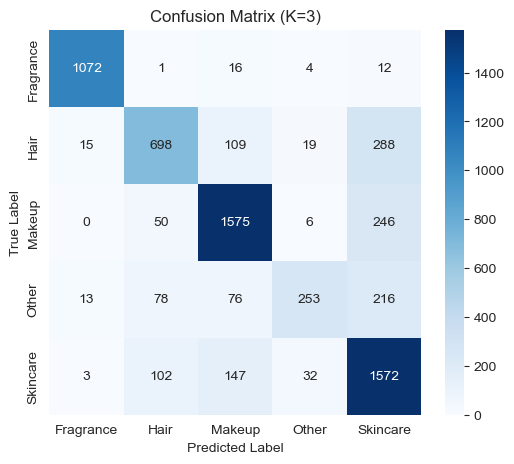

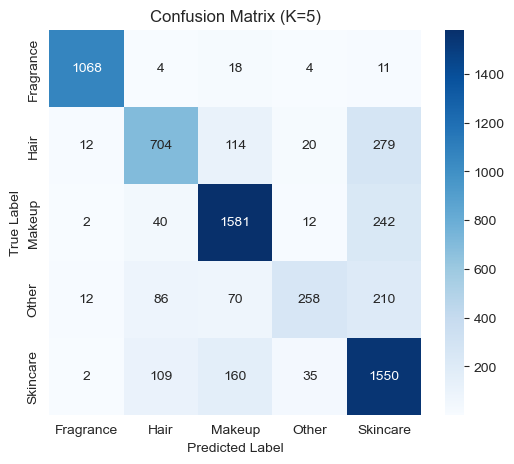

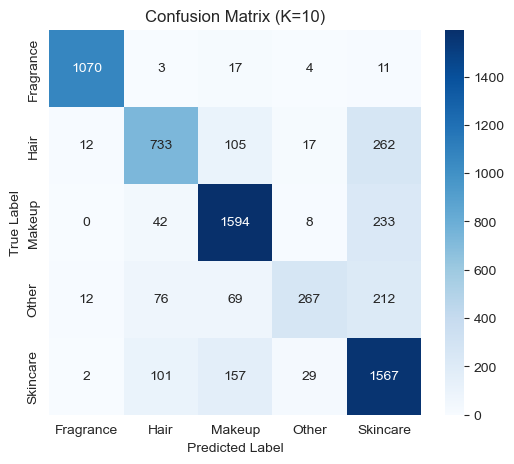

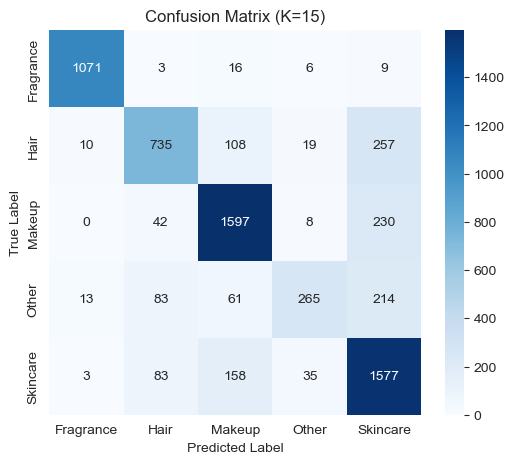

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Extract features (ingredient embeddings) and labels (primary category)
X = np.vstack(data['ingredient_embeddings'])
y = data['primary_category']

# Try different K values
k_values = [3, 5, 10, 15]
confusion_matrices = {}

for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    model = RandomForestClassifier(random_state=42)

    all_y_true = []
    all_y_pred = []

    # Perform manual cross-validation
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    # Compute the confusion matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    confusion_matrices[k] = cm

    # Display the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix (K={k})")
    plt.show()


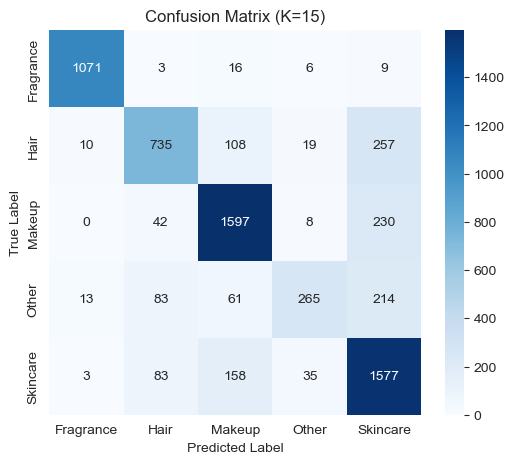


Final Classification Report for Test Data (Averaged Over Folds):

Label           Precision  Recall     F1-score   Support
Fragrance       0.976299   0.969231   0.972752   1105.0    
Hair            0.776956   0.651019   0.708434   1129.0    
Makeup          0.823196   0.850826   0.836783   1877.0    
Other           0.795796   0.416667   0.546956   636.0     
Skincare        0.689550   0.849677   0.761284   1856.0    

Macro Avg       0.812359   0.747484   0.765242   6603.0    
Weighted Avg    0.800706   0.794336   0.788454   6603.0    
Accuracy        0.794336  



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Extract features (ingredient embeddings) and labels (primary category)
X = np.vstack(data['ingredient_embeddings'])
y = data['primary_category']

# Use only K=15
k = 15
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
model = RandomForestClassifier(random_state=42)

all_y_true = []
all_y_pred = []

# Perform manual cross-validation
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Display the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (K={k})")
plt.show()

# Generate and print classification report with accuracy
report = classification_report(all_y_true, all_y_pred, digits=6, output_dict=True)

# Add overall accuracy
report["accuracy"] = accuracy_score(all_y_true, all_y_pred)

# Print classification report in a similar format to the image
print("\nFinal Classification Report for Test Data (Averaged Over Folds):\n")
print(f"{'Label':<15} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Support'}")
for label, metrics in report.items():
    if label not in ["accuracy", "macro avg", "weighted avg"]:
        print(f"{label:<15} {metrics['precision']:<10.6f} {metrics['recall']:<10.6f} {metrics['f1-score']:<10.6f} {metrics['support']:<10.1f}")

# Print macro avg, weighted avg, and overall accuracy
print(f"\n{'Macro Avg':<15} {report['macro avg']['precision']:<10.6f} {report['macro avg']['recall']:<10.6f} {report['macro avg']['f1-score']:<10.6f} {report['macro avg']['support']:<10.1f}")
print(f"{'Weighted Avg':<15} {report['weighted avg']['precision']:<10.6f} {report['weighted avg']['recall']:<10.6f} {report['weighted avg']['f1-score']:<10.6f} {report['weighted avg']['support']:<10.1f}")
print(f"{'Accuracy':<15} {report['accuracy']:<10.6f}\n")


# Random forest with UMAP

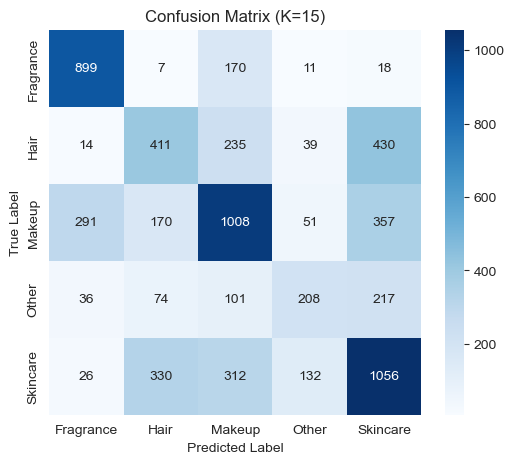


Final Classification Report for Test Data (Averaged Over Folds):

Label           Precision  Recall     F1-score   Support
Fragrance       0.710111   0.813575   0.758330   1105.0    
Hair            0.414315   0.364039   0.387553   1129.0    
Makeup          0.552026   0.537027   0.544423   1877.0    
Other           0.471655   0.327044   0.386258   636.0     
Skincare        0.508181   0.568966   0.536858   1856.0    

Macro Avg       0.531258   0.522130   0.522685   6603.0    
Weighted Avg    0.534869   0.542481   0.536037   6603.0    
Accuracy        0.542481  



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA  # Import PCA

# Extract features (ingredient embeddings) and labels (primary category)
X = np.vstack(data['ingredient_embeddings'])
y = data['primary_category']

# Apply PCA for dimensionality reduction
pca_reducer = PCA(n_components=2, random_state=42)  # Reduce to 2 dimensions (or adjust as needed)
X_reduced = pca_reducer.fit_transform(X)

# Use only K=15
k = 15
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
model = RandomForestClassifier(random_state=42)

all_y_true = []
all_y_pred = []

# Perform manual cross-validation
for train_idx, test_idx in skf.split(X_reduced, y):
    X_train, X_test = X_reduced[train_idx], X_reduced[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred)

# Display the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (K={k})")
plt.show()

# Generate and print classification report with accuracy
report = classification_report(all_y_true, all_y_pred, digits=6, output_dict=True)

# Add overall accuracy
report["accuracy"] = accuracy_score(all_y_true, all_y_pred)

# Print classification report in a similar format to the image
print("\nFinal Classification Report for Test Data (Averaged Over Folds):\n")
print(f"{'Label':<15} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Support'}")
for label, metrics in report.items():
    if label not in ["accuracy", "macro avg", "weighted avg"]:
        print(f"{label:<15} {metrics['precision']:<10.6f} {metrics['recall']:<10.6f} {metrics['f1-score']:<10.6f} {metrics['support']:<10.1f}")

# Print macro avg, weighted avg, and overall accuracy
print(f"\n{'Macro Avg':<15} {report['macro avg']['precision']:<10.6f} {report['macro avg']['recall']:<10.6f} {report['macro avg']['f1-score']:<10.6f} {report['macro avg']['support']:<10.1f}")
print(f"{'Weighted Avg':<15} {report['weighted avg']['precision']:<10.6f} {report['weighted avg']['recall']:<10.6f} {report['weighted avg']['f1-score']:<10.6f} {report['weighted avg']['support']:<10.1f}")
print(f"{'Accuracy':<15} {report['accuracy']:<10.6f}\n")